# Geolocate IP addresses and calculate distance

## Introduction

- UUID: **81ba2210-5052-49f4-9d6a-41d42d28ca45**
- Started from [issue 20](https://github.com/MISP/misp-playbooks/issues/20)
- State: **Published** : demo version with **output**
- Purpose: This playbook gets the IP addresess in a MISP event (ip-src and ip-dst). It then queries for the geolocation of these addresses via MMDB, puts them on a map and calculates the distance between coordinates with the help of Geopy. The map is attached as a screenshot to the MISP event, the findings are added as a MISP report, stored in the playbook and sent to Mattermost.
- Tags: [ "geolocation", "fingerprint", "geoint", "mmdb", "infrastructure"]
- External resources: **Mattermost**, **MMDB**, **OpenStreetMap**
- Target audience: **CTI**, **SOC**, **CSIRT**

[![](https://mermaid.ink/img/pako:eNptU01v2zAM_SuCgFyCGLv7sF16CdACxbJbFLSyxcRC9WFIdIsg8H8fJStyu84XmeQj3xNJ3XjvFfCWN00jHGo00LKn_eGZjUZeO-_fhMuhzeamncaW3QQ_G__RDzKg4Nke0JpH2YGJyXGWJsI8s3mzEa5C2eNv4Rh98A4O4zFxnBZPnLpLkOPAJGLQ3YTwEkGGfmCfUWsQryMcBU8H02MTQ_-DDhVJzikhC75H7Z3sDJBC9C9axV-Cz0WEUytyUcSahh0W2qb5udLFr2ZmX1yVQLh_KVOxP2FagNop3Uv0IZLq_TOTSgWIEahbp3vqiskpH4PXy5-1qltcPhhl5VhEV7_SEaXrq4jaTe3eIaK-SAR23K9G6WemWGsVZyFZrLV06dmdo2pJAnL7Aoye9uFL2v-j69W-hT45qFN5C0uYF9HfcLlQnKyV4br0iyYFwfqI93bkGNV7fdAxLXWFa1eX_LUyrPkp5UBEzHnU5zQdGi5Dz7bbpwrablMq33FLttSKXtItFaKVG8BCeg-CKzjLydAthJsJKif0h6vreYu0Ijse_HQZeJvfzY5Po6IhPWhJU7TFO_8Fw7469g?type=png)](https://mermaid.live/edit#pako:eNptU01v2zAM_SuCgFyCGLv7sF16CdACxbJbFLSyxcRC9WFIdIsg8H8fJStyu84XmeQj3xNJ3XjvFfCWN00jHGo00LKn_eGZjUZeO-_fhMuhzeamncaW3QQ_G__RDzKg4Nke0JpH2YGJyXGWJsI8s3mzEa5C2eNv4Rh98A4O4zFxnBZPnLpLkOPAJGLQ3YTwEkGGfmCfUWsQryMcBU8H02MTQ_-DDhVJzikhC75H7Z3sDJBC9C9axV-Cz0WEUytyUcSahh0W2qb5udLFr2ZmX1yVQLh_KVOxP2FagNop3Uv0IZLq_TOTSgWIEahbp3vqiskpH4PXy5-1qltcPhhl5VhEV7_SEaXrq4jaTe3eIaK-SAR23K9G6WemWGsVZyFZrLV06dmdo2pJAnL7Aoye9uFL2v-j69W-hT45qFN5C0uYF9HfcLlQnKyV4br0iyYFwfqI93bkGNV7fdAxLXWFa1eX_LUyrPkp5UBEzHnU5zQdGi5Dz7bbpwrablMq33FLttSKXtItFaKVG8BCeg-CKzjLydAthJsJKif0h6vreYu0Ijse_HQZeJvfzY5Po6IhPWhJU7TFO_8Fw7469g)

# Playbook

- **Geolocate IP addresses and calculate distance**
    - Introduction
- **Preparation**
    - PR:1 Initialise environment
    - PR:2 Set helper variables
    - PR:3 Setup MISP event link
- **Investigation**
    - IN:1 Get network owner information from whois
    - IN:2 Get geolocation from MMDB
    - IN:3 Output whois and geolocation in a table
    - IN:4 Plots the results on a world map
    - IN:5 Calculate the distance between source and destination IP
    - IN:6 Create MISP report
- **Closure**
    - EN:1 Create the summary of the playbook 
    - EN:2 Print the summary
    - EN:3 Send a summary to Mattermost
    - EN:4 End of the playbook 
- External references
- Technical details

# Preparation

## PR:1 Initialise environment

This section **initialises the playbook environment** and loads the required Python libraries. 

The credentials for MISP (**API key**) and other services are loaded from the file `keys.py` in the directory **vault**. A [PyMISP](https://github.com/MISP/PyMISP) object is created to interact with MISP and the active MISP server is displayed. By printing out the server name you know that it's possible to connect to MISP. In case of a problem PyMISP will indicate the error with `PyMISPError: Unable to connect to MISP`.

The contents of the `keys.py` file should contain at least :

```
misp_url="<MISP URL>"                  # The URL to our MISP server
misp_key="<MISP API KEY>"              # The MISP API key
misp_verifycert=<True or False>        # Ignore certificate errors
mattermost_playbook_user="<MATTERMOST USER>"
mattermost_hook="<MATTERMOST WEBHOOK>"
```

In [1]:
# Initialise Python environment
import urllib3
import sys
import json
from pyfaup.faup import Faup
from prettytable import PrettyTable, MARKDOWN
from IPython.display import Image, display, display_markdown, HTML
from datetime import date
import requests
import uuid
from uuid import uuid4
from pymisp import *
from pymisp.tools import GenericObjectGenerator

import re
import time
from datetime import datetime

from geopy.distance import geodesic
from ipwhois import IPWhois
import geopandas as gpd
import matplotlib.pyplot as plt
from io import BytesIO
import base64

# Load the credentials
sys.path.insert(0, "../vault/")
from keys import *
if misp_verifycert is False:
    import urllib3
    urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
print("The \033[92mPython libraries\033[90m are loaded and the \033[92mcredentials\033[90m are read from the keys file.")

# Create the PyMISP object
misp = PyMISP(misp_url, misp_key, misp_verifycert)
misp_headers = {"Authorization": misp_key,  "Content-Type": "application/json", "Accept": "application/json"}
print("I will use the MISP server \033[92m{}\033[90m for this playbook.".format(misp_url))

/tmp/ipykernel_118191/2220793782.py:12: DeprecationWarning: 
As our baseline system is the latest Ubuntu LTS, and Ubuntu LTS 22.04 has Python 3.10 available,
we will officially deprecate python versions below 3.10 on January 1st 2024.
**Please update your codebase.**
  from pymisp import *


The Python libraries are loaded and the credentials are read from the keys file.
I will use the MISP server https://misp.demo.cudeso.be/ for this playbook.


## PR:2 Set helper variables

This cell contains **helper variables** that are used in this playbook. Their usage is explained in the next steps of the playbook.

- `playbook_config` : the configuration of the playbook
- `playbook_results` : the results of the playbook

In [2]:
playbook_config = {"map_title": "Geolocation of IP addresses",
                   "mapcolour": "lightgray",
                   "mapedgecolour": "darkgray",
                   "pointcoloursrc": "red",
                   "pointcolourdst": "blue",
                   "pointsize": 6,                   
                   "textcoloursrc": "red",
                   "textcolourdst": "blue", #"#333333", #"#0000CC",                   
                   "textsize": 8,
                   "network_attributes": ["ip-src", "ip-dst"],
                   "published": True,
                   "to_ids": True,
                   "mmdb_url": "https://ip.circl.lu/geolookup/",
                    }

playbook_results = {"eventtitle": False,
                    "eventid" : False,
                    "source": [],
                    "destination": [],
                    "geolocation": {},
                    "whois": {},
                    "distance": ""
                    }

## PR:3 Setup MISP event link

Provide an **MISP event ID** or **MISP event UUID** via the variable `event_input`. The playbook will then load all IP (ip-src, ip-dst) attributes.

In [3]:
# MISP event ID or event UUID
event_input = "4baee83f-c26b-47c6-949a-70b5ec6c5d25"

In [4]:
print("Search for  MISP event \033[92m{}\033[90m".format(event_input))

result = misp.search("events", eventid=event_input, published=playbook_config["published"], pythonify=True)
if len(result) == 1:
    misp_event = result[0]
    print(" Found event \033[92m{}\033[90m".format(misp_event.info))
    playbook_results["eventtitle"] = misp_event.info
    playbook_results["eventid"] = misp_event.id
    print(" Check for IP addresses")
    attributes = misp.search("attributes", eventid=event_input, type_attribute=playbook_config["network_attributes"], to_ids=playbook_config["to_ids"], pythonify=True)
    if len(attributes) > 0:
        print("  Found \033[92m{}\033[90m attributes".format(len(attributes)))
        for attribute in attributes:
            print("   {}".format(attribute.value))
            #playbook_results["attributes"].append(attribute.value)
            if attribute.type == "ip-src":
                playbook_results["source"].append(attribute.value)
            elif attribute.type == "ip-dst":
                playbook_results["destination"].append(attribute.value)
    print("Finished searching")
else:
    print("\033[91mUnable to get MISP event\033[90m")

Search for  MISP event 4baee83f-c26b-47c6-949a-70b5ec6c5d25
 Found event Workstation compromise
 Check for IP addresses
  Found 5 attributes
   193.191.206.122
   68.76.150.97
   174.53.242.108
   37.191.122.186
   41.240.12.55
Finished searching


# Investigate

## IN:1 Get network owner information from whois

The first investigation step in this playbook is to query the Whois database and obtain the **network description**, **ASN** number and the network block the IP address belongs to.

In [5]:
def get_whois(value):
    try:
        obj = IPWhois(value)
        results = obj.lookup_rdap()
        asn = results["asn"]
        asn_description = results["asn_description"]
        asn_cidr = results["asn_cidr"]
        print(" Found asn: {} description: {} cidr {}".format(asn, asn_description, asn_cidr))
        return {"asn": asn, "asn_description": asn_description, "asn_cidr": asn_cidr}
    except:
        return {"asn": 0, "asn_description": "", "asn_cidr": ""}

print("Search whois")
for value in playbook_results["source"]:
    print("Query (source) \033[92m{}\033[90m".format(value))
    playbook_results["whois"][value] = get_whois(value)
for value in playbook_results["destination"]:
    print("Query (destination) \033[92m{}\033[90m".format(value))
    playbook_results["whois"][value] = get_whois(value)  
print("Finished whois")

Search whois
Query (source) 68.76.150.97
 Found asn: 7018 description: ATT-INTERNET4, US cidr 68.76.0.0/15
Query (source) 174.53.242.108
 Found asn: 7922 description: COMCAST-7922, US cidr 174.48.0.0/12
Query (source) 37.191.122.186
 Found asn: 42973 description: METRONETUK_M24SEVEN, GB cidr 37.191.96.0/19
Query (source) 41.240.12.55
 Found asn: NA description: NA cidr NA
Query (destination) 193.191.206.122
 Found asn: 2611 description: BELNET, BE cidr 193.191.192.0/19
Finished whois


## IN:2 Get geolocation from MMDB

After getting the whois data, the playbook uses an MMDB service to identify the **geolocation**, with latitude and longitude. In this playbook it uses [ip.circl.lu](https://ip.circl.lu/geolookup/) as MMDB server.

In [6]:
def get_mmdb(value):
    headers = {}
    response = requests.request("GET", "{}{}".format(playbook_config["mmdb_url"], value), headers={})
    if response.status_code == 200:
        result_json = response.json()[0]
        iso_code = result_json.get("country", False).get("iso_code", False)
        lat = result_json.get("country_info", False).get("Latitude (average)", False)
        long = result_json.get("country_info", False).get("Longitude (average)", False)
        direction = "dst"
        if value in playbook_results["source"]:
            direction = "src"
        print(" Found lat: {} long: {} ISO {}".format(lat, long, iso_code))
        return {"lat": lat, "long": long, "iso_code": iso_code, "direction": direction}
    else:
        return {}
    
print("Search MMDB")
for value in playbook_results["source"]:
    print("Query (source) \033[92m{}\033[90m".format(value))
    playbook_results["geolocation"][value] = get_mmdb(value)
for value in playbook_results["destination"]:
    print("Query (destination) \033[92m{}\033[90m".format(value))
    playbook_results["geolocation"][value] = get_mmdb(value)    
print("Finished MMDB")

Search MMDB
Query (source) 68.76.150.97
 Found lat: 38 long: -97 ISO US
Query (source) 174.53.242.108
 Found lat: 38 long: -97 ISO US
Query (source) 37.191.122.186
 Found lat: 54 long: -2 ISO GB
Query (source) 41.240.12.55
 Found lat: 15 long: 30 ISO SD
Query (destination) 193.191.206.122
 Found lat: 50.8333 long: 4 ISO BE
Finished MMDB


## IN:3 Output whois and geolocation in a table

Before we go to the next step, the playbook already gives you a nice table with the obtained information. This information is also sent to Mattermost and added as a MISP **event report**.

In [7]:
table = PrettyTable()
table.field_names = ["IP", "Type", "ASN", "ASN Description", "CIDR", "Country", "Lat", "Long"]
table.align["IP"] = "l"
table.align["Type"] = "l"
table.align["ASN"] = "l"
table.align["ASN Description"] = "l"

for ip in playbook_results["source"]:
    table.add_row([ip, "source", playbook_results["whois"][ip]["asn"], playbook_results["whois"][ip]["asn_description"], 
                           playbook_results["whois"][ip]["asn_cidr"], 
                           playbook_results["geolocation"][ip]["iso_code"],
                           playbook_results["geolocation"][ip]["lat"],
                           playbook_results["geolocation"][ip]["long"]])
for ip in playbook_results["destination"]:
    table.add_row([ip, "destination", playbook_results["whois"][ip]["asn"], playbook_results["whois"][ip]["asn_description"], 
                           playbook_results["whois"][ip]["asn_cidr"], 
                           playbook_results["geolocation"][ip]["iso_code"],
                           playbook_results["geolocation"][ip]["lat"],
                           playbook_results["geolocation"][ip]["long"]])
print(table.get_string(sortby="IP"))
table_ipdata = table

+-----------------+-------------+-------+-------------------------+------------------+---------+---------+------+
| IP              | Type        | ASN   | ASN Description         |       CIDR       | Country |   Lat   | Long |
+-----------------+-------------+-------+-------------------------+------------------+---------+---------+------+
| 174.53.242.108  | source      | 7922  | COMCAST-7922, US        |  174.48.0.0/12   |    US   |    38   | -97  |
| 193.191.206.122 | destination | 2611  | BELNET, BE              | 193.191.192.0/19 |    BE   | 50.8333 |  4   |
| 37.191.122.186  | source      | 42973 | METRONETUK_M24SEVEN, GB |  37.191.96.0/19  |    GB   |    54   |  -2  |
| 41.240.12.55    | source      | NA    | NA                      |        NA        |    SD   |    15   |  30  |
| 68.76.150.97    | source      | 7018  | ATT-INTERNET4, US       |   68.76.0.0/15   |    US   |    38   | -97  |
+-----------------+-------------+-------+-------------------------+------------------+--

## IN:4 Plots the results on a world map

To visualise the geolocation of the IP addresses the playbook also maps them on a world map. There's a differentiation between source IP (`ip-src`) and destination IP (`ip-dst`). The map is also attached as a screenshot to the MISP event and sent to Mattermost afterwards.

Start creating the map


/tmp/ipykernel_118191/3535114992.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


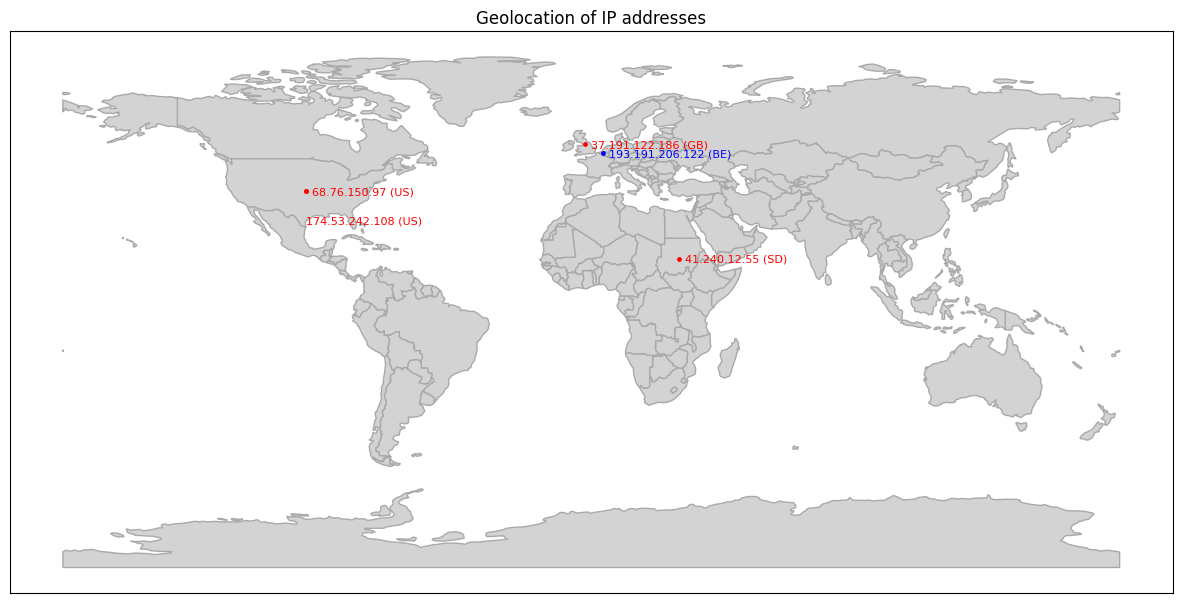

In [8]:
print("Start creating the map")
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
fig, ax = plt.subplots(figsize=(15, 10))
world.plot(ax=ax, color=playbook_config["mapcolour"], edgecolor=playbook_config["mapedgecolour"])

placed_labels = []
for ip, data in playbook_results["geolocation"].items():
    lat = float(data['lat'])
    long = float(data['long'])
    iso_code = data['iso_code']
    
    if ip in playbook_results["source"]:
        plt.scatter(long, lat, color=playbook_config["pointcoloursrc"], s=playbook_config["pointsize"])
        textcolour = playbook_config["textcoloursrc"]        
    else:
        plt.scatter(long, lat, color=playbook_config["pointcolourdst"], s=playbook_config["pointsize"])
        textcolour = playbook_config["textcolourdst"]
    
    label = f"{ip} ({iso_code})"
    overlap = False
    for placed_label in placed_labels:
        prev_long, prev_lat, prev_text = placed_label
        if abs(long - prev_long) < 2 and abs(lat - prev_lat) < 2:
            overlap = True
            break

    if overlap:
        plt.text(long, lat - 10, label, fontsize=playbook_config["textsize"], ha='left', va='center', color=textcolour)
    else:
        plt.text(long + 2, lat, label, fontsize=playbook_config["textsize"], ha='left', va='center', color=textcolour)
    
    placed_labels.append((long, lat, label))

ax.set_xticks([])
ax.set_yticks([])
plt.title(playbook_config["map_title"])

buf = BytesIO()
plt.savefig(buf, format='png')
buf.seek(0)

# Add to MISP
attribute = MISPAttribute()
attribute.type = "attachment"
attribute.category = "Payload delivery"
attribute.value = "{}.png".format(uuid.uuid4())
attribute.data = base64.b64encode(buf.read()).decode('utf-8')
attribute.to_ids = False
attribute.comment = playbook_config["map_title"]
attribute.disable_correlation = True
misp.add_attribute(playbook_results["eventid"], attribute)

plot_as_string = buf.getvalue()
buffer_base64 = base64.b64encode(plot_as_string).decode()
        
# Store it for later use
base64_image = attribute.data

plt.show()

## IN:5 Calculate the distance between source and destination IP

The final investigation step in this playbook calculates the distance between the source (`ip-src`) and destination (`ip-dst`) IPs.

In [9]:
print("Start calculating")

for source_ip in playbook_results["source"]:
    source_coords = (float(playbook_results["geolocation"][source_ip]["lat"]),
                     float(playbook_results["geolocation"][source_ip]["long"]))
    
    for destination_ip in playbook_results["destination"]:
        destination_coords = (float(playbook_results["geolocation"][destination_ip]["lat"]),
                              float(playbook_results["geolocation"][destination_ip]["long"]))
        
        distance = geodesic(source_coords, destination_coords).kilometers
        distance_str = f"Distance between {source_ip} and {destination_ip} is {distance:.2f} km."
        playbook_results["distance"] = "{}\n\n{}".format(playbook_results["distance"], distance_str)
        print(" {}".format(distance_str))
print("Finished calculating")

Start calculating
 Distance between 68.76.150.97 and 193.191.206.122 is 7527.32 km.
 Distance between 174.53.242.108 and 193.191.206.122 is 7527.32 km.
 Distance between 37.191.122.186 and 193.191.206.122 is 538.95 km.
 Distance between 41.240.12.55 and 193.191.206.122 is 4608.22 km.
Finished calculating


## IN:6 Create MISP report

We add our findings to the MISP event as a MISP report. The summary that we create as a MISP report is also send as the summary to Mattermost.

In [10]:
print("Creating MISP summary")
report_title = "MISP Playbook summary: Geolocate IP addresses and calculate distance"
summary = "# {} \n\n".format(report_title)

current_date = datetime.now()
formatted_date = current_date.strftime("%Y-%m-%d")
summary += "## Overview\n\n"
summary += "This concerned the investigation of \n"
summary += "- Source IPs: "
for value in playbook_results["source"]:
    summary += "**{}** ".format(value)
summary += "\n- Destination IPs: " 
for value in playbook_results["destination"]:
    summary += "**{}** ".format(value)
summary += "\n"    
summary += "- Date: **{}**\n".format(formatted_date)
summary += "- Event: **{}** ({})\n".format(playbook_results["eventtitle"], playbook_results["eventid"])
summary += "\n\n"

summary += "## IP details\n\n"
summary += "### Whois and geolocation\n\n"
table_ipdata.set_style(MARKDOWN)
summary += table_ipdata.get_string(sortby="IP")
summary += "\n\n"
summary += "### Distance\n\n"
summary += playbook_results["distance"]

summary += "\n\n"

print("The \033[92msummary\033[90m of the playbook is available.\n")

print("Creating MISP event reports")
event_title = report_title
chunk_size = 61500
for i in range(0, len(summary), chunk_size):
    chunk = summary[i:i + chunk_size]
    event_report = MISPEventReport()
    event_title_edit = event_title
    if i > 0:
        event_title_edit = "{} ({} > {})".format(event_title, i, i + chunk_size)
    event_report.name = event_title_edit
    event_report.content = chunk
    result = misp.add_event_report(playbook_results["eventid"], event_report)
    if "EventReport" in result:
        print(" Report ID: \033[92m{}\033[90m".format(result.get("EventReport", []).get("id", 0)))
    else:
        print(" Failed to create report for \033[91m{}\033[90m.".format(event_title))

Creating MISP summary
The summary of the playbook is available.

Creating MISP event reports
 Report ID: 924


# Closure

In this **closure** or end step we create a **summary** of the actions that were performed by the playbook. The summary is printed and can also be send to a chat channel. 

## EN:1 Create the summary of the playbook 

The summary of the playbook was already created previously (when it created the MISP report). We keep this section here for consistency with other MISP playbooks.

## EN:2 Print the summary

In [11]:
print(summary)
# Or print with parsed markdown
#display_markdown(summary, raw=True)

# MISP Playbook summary: Geolocate IP addresses and calculate distance 

## Overview

This concerned the investigation of 
- Source IPs: **68.76.150.97** **174.53.242.108** **37.191.122.186** **41.240.12.55** 
- Destination IPs: **193.191.206.122** 
- Date: **2024-08-16**
- Event: **Workstation compromise** (3503)


## IP details

### Whois and geolocation

| IP              | Type        | ASN   | ASN Description         |       CIDR       | Country |   Lat   | Long |
|:----------------|:------------|:------|:------------------------|:----------------:|:-------:|:-------:|:----:|
| 174.53.242.108  | source      | 7922  | COMCAST-7922, US        |  174.48.0.0/12   |    US   |    38   | -97  |
| 193.191.206.122 | destination | 2611  | BELNET, BE              | 193.191.192.0/19 |    BE   | 50.8333 |  4   |
| 37.191.122.186  | source      | 42973 | METRONETUK_M24SEVEN, GB |  37.191.96.0/19  |    GB   |    54   |  -2  |
| 41.240.12.55    | source      | NA    | NA                      |   

## EN:3 Send a summary to Mattermost

Now you can send the summary to Mattermost. You can send the summary in two ways by selecting one of the options for the variable `send_to_mattermost_option` in the next cell.

- The default option where the entire summary is in the **chat**, or
- a short intro and the summary in a **card**

For this playbook we rely on a webhook in Mattermost. You can add a webhook by choosing the gear icon in Mattermost, then choose Integrations and then **Incoming Webhooks**. Set a channel for the webhook and lock the webhook to this channel with *"Lock to this channel"*.

In [12]:
send_to_mattermost_option = "via a chat message"
#send_to_mattermost_option = "via a chat message with card"

In [13]:
message = False

data_url = f"data:image/png;base64,{buffer_base64}"
attachment = [{"fallback": report_title , "color": "#ff8000", "image_url": data_url}]

if send_to_mattermost_option == "via a chat message":
    message = {"username": mattermost_playbook_user, "text": summary, "attachments": attachment}
elif send_to_mattermost_option == "via a chat message with card":
    message = {"username": mattermost_playbook_user, "text": intro, "props": {"card": summary}, "attachments": attachment}

if message:
    r = requests.post(mattermost_hook, data=json.dumps(message))
    r.raise_for_status()
if message and r.status_code == 200:
    print("Summary is \033[92msent to Mattermost.\n")
else:
    print("\033[91mFailed to sent summary\033[90m to Mattermost.\n")

Summary is sent to Mattermost.



## EN:4 End of the playbook 

In [14]:
print("\033[92m End of the playbook")


 End of the playbook


## External references <a name="extreferences"></a>

- [The MISP Project](https://www.misp-project.org/)
- [Mattermost](https://mattermost.com/)

## Technical details 

### Documentation

This playbook requires these Python **libraries** to exist in the environment where the playbook is executed. You can install them with `pip install <library>`.

```
PrettyTable
ipywidgets
ipwhois
geopy
geopandas
matplotlib
```

### Colour codes

The output from Python displays some text in different colours. These are the colour codes

```
Red = '\033[91m'
Green = '\033[92m'
Blue = '\033[94m'
Cyan = '\033[96m'
White = '\033[97m'
Yellow = '\033[93m'
Magenta = '\033[95m'
Grey = '\033[90m'
Black = '\033[90m'
Default = '\033[99m'
```